In [1]:
import numpy as np
import pandas as pd
import os
import time
import json
import gc
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 0. Load

In [2]:
train = pd.read_feather('/home/leechh/tempfile/R/train.feather')

In [3]:
idx = train.totals_transactionRevenue.notnull()
train = train[idx].reset_index().drop(['index'],axis=1)

gc.collect()

39

In [4]:
train.head(3)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,...,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Direct,20160902,6194193421514403509,6194193421514403509_1472843572,Not Socially Engaged,1472843572,1,1472843572,Chrome,not available in demo dataset,...,None,None,None,(not set),None,True,None,(none),None,(direct)
1,Organic Search,20160902,5327166854580374902,5327166854580374902_1472844906,Not Socially Engaged,1472844906,3,1472844906,Chrome,not available in demo dataset,...,None,None,None,(not set),None,True,(not provided),organic,None,google
2,Referral,20160902,8885051388942907862,8885051388942907862_1472827393,Not Socially Engaged,1472827393,7,1472827393,Chrome,not available in demo dataset,...,None,None,None,(not set),None,True,None,referral,/,mall.googleplex.com


## 1. totals_transactionRevenue
首先呢，我们先看看我们要预测的transactionRevenue 大概是什么样，

In [5]:
train['totals_transactionRevenue'] = train.totals_transactionRevenue.astype('float')
train['target'] = np.log1p(train.totals_transactionRevenue+1)
train['real'] = train.totals_transactionRevenue/(10**6)

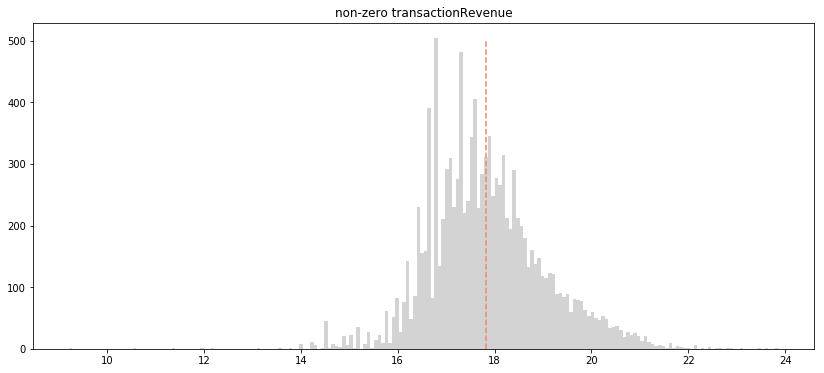

In [6]:
def plotRevence():
    nozero = sum(idx)
    iszero = train.shape[0] - nozero
    plt.figure(figsize=[14,6])
    revenue = np.log1p(train.totals_transactionRevenue.astype('float')+1)
    plt.hist(revenue, 
             bins=200, 
             color='lightgray')
    plt.plot([np.average(revenue),np.average(revenue)],[0,500],c='salmon',linestyle='--')
    plt.title('non-zero transactionRevenue')
    plt.show()
    return None


plotRevence()

在经过ln之后基本符合正态分布，这是个不错的开始。

## 2. channelGrouping 

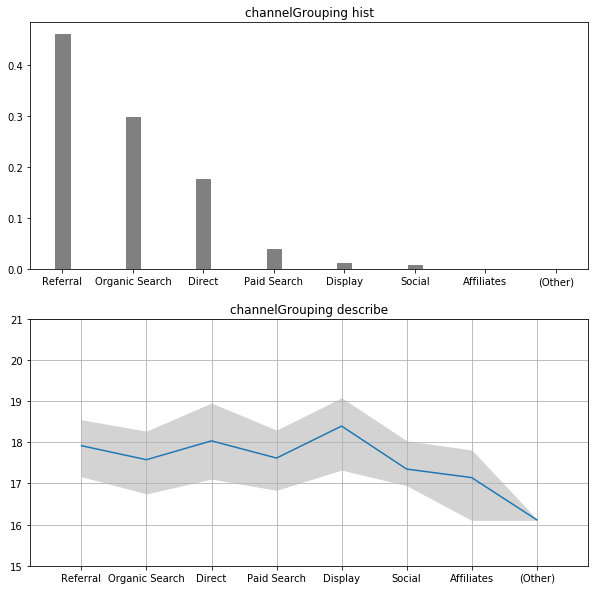

In [7]:
def plotclass(features,df=train,top=False,size=[10,10],score='target'):
    feature = []
    featurelist = ['count','mean','std','min','25%','50%','75%','max']
    for i in featurelist:
        if top == False:
            feature.append(df.groupby(features).describe()[score].sort_values('count',ascending=False)[0:][i])   
        else:
            feature.append(df.groupby(features).describe()[score].sort_values('count',ascending=False)[0:top][i]) 
    shape = feature[0].shape[0]
    
    plt.figure(figsize=size)
    plt.subplot(2,1,1)
    plt.bar(np.arange(shape),
            feature[0].values/df.shape[0],
            width=np.ones(shape)*0.2,
            facecolor='gray',
            edgecolor='gray',
            tick_label=feature[0].index.values.astype('str'))
    plt.title(f'{features} hist')

    plt.subplot(2,1,2)
    plt.bar(np.arange(shape),
            np.zeros(shape),
            tick_label=feature[0].index.values)
    plt.plot(np.arange(shape),
             feature[1].values)
    plt.fill_between(np.arange(shape),
                     feature[4].values,
                     feature[6].values,
                     color='lightgray')
    plt.grid()
    plt.title(f'{features} describe')
    plt.ylim([15,21])
    plt.show()
    return None

plotclass('channelGrouping')

##### 第一类：市场投放活动（Campaigns）  
这一类比较常见的是付费关键词即Adwords，如果是Adwords，你不用加码，GA也能非常好的识别出来。当然如果你给自己的某个外部投放加上码，GA也    会认为它是一个投放活动。投放活动在GA所有流量来源里，优先级别是最高的。

##### 第二类：自然搜索（Organic）  
这个大家很理解，就是Google和Baidu等自然搜索引入的流量。它对于GA来说，优先级别与Adwords是一样的。

##### 第三类：推介网站（Referral）  
这一渠道的流量主要是指从其他网站点过来的链接，比如友情链接等，这类来源通常是免费的。这一来源的优先级别低于市场投放活动和自然搜索。

##### 第四类：直接输入（Direct）  
直接输入包括几个方面，一个是直接在地址里输入网站，第二个是利用收藏夹与标签，第三个是从桌面软件，比如从QQ，MSN等软件点过来的链接，第四个是如果无法判别流量来源的话，也会归入直接输入。这个来源的优先级是最低的，大家抢的都是这个流量。

##### 结论：onehot展开

## 3. sessionId
我觉得seesionId 应该就是fullvisitId 与 visitId 的结合，验证以下，如果是的话，我们就可以把 这个features去掉了。

In [8]:
print('fullvisitId sess diff:',sum(train.sessionId.str.split('_',expand=True)[0] != train.fullVisitorId))
print('visitId sess diff:',sum(train.sessionId.str.split('_',expand=True)[1] != train.visitId.astype('str')))

fullvisitId sess diff: 0
visitId sess diff: 0


In [9]:
train.drop(['sessionId'],axis=1,inplace=True)

## 4.date
接下来，把时间date转化为时间格式

In [10]:
train['date'] = pd.to_datetime(train.date,format='%Y%m%d')

In [11]:
holiidx = (train.date > '2016-11-24') & (train.date < '2016-12-25')

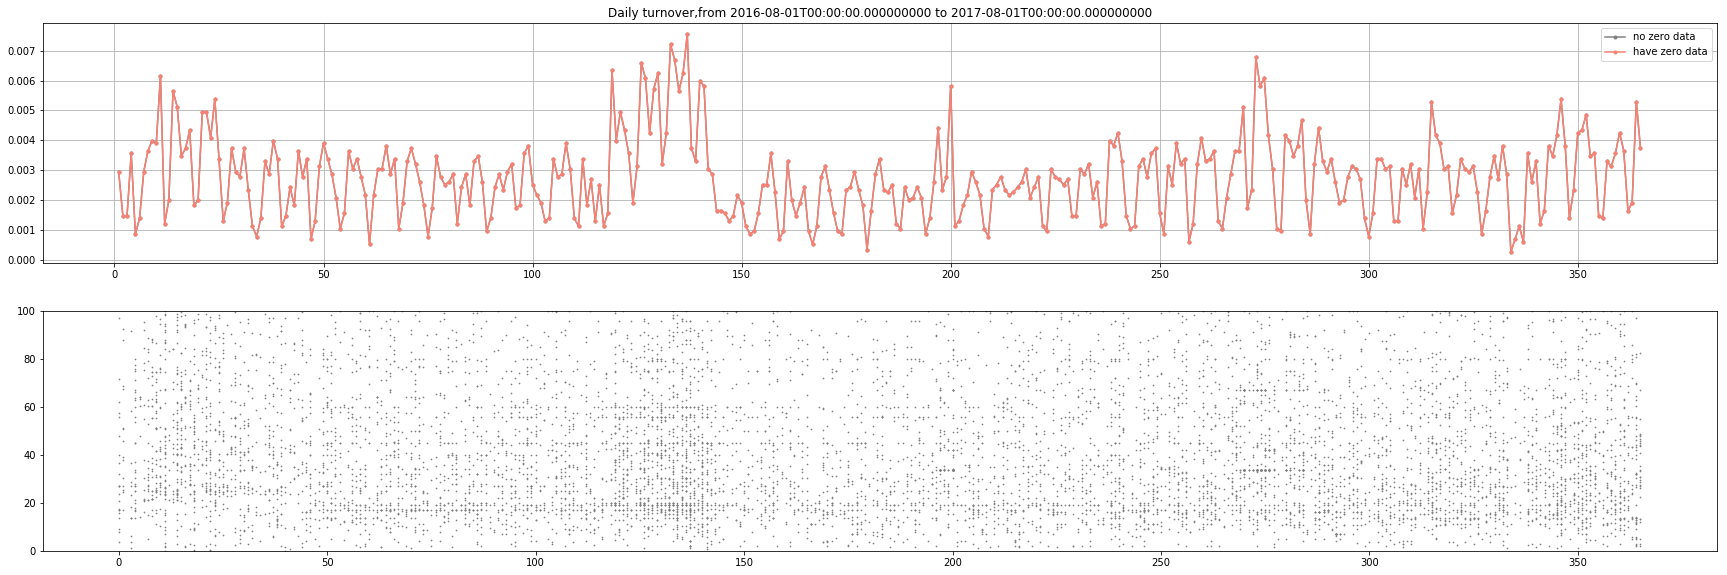

In [12]:


def plotdate():
    idx = train.totals_transactionRevenue.notnull()
    datetime1 = train[idx].date.value_counts(normalize=True).sort_index()
    datetime2 = train.date.value_counts(normalize=True).sort_index()
    
    date1 =  train[idx].date.value_counts().sort_index()
    date2 = train.date.value_counts().sort_index()
    
    tofirst = np.array([i.days for i in train[idx].date-datetime1.index.values[0]])
    plt.figure(figsize=[30,15])
    plt.subplot(3,1,1)
    plt.title(f'Daily turnover,from {datetime1.index.values[0]} to {datetime1.index.values[-1]}')
    plt.plot(np.arange(datetime1.shape[0])+1,
             datetime1.values,
             '.-',
             c='gray',
             label='no zero data')
    plt.plot(np.arange(datetime2.shape[0])+1,
             datetime2.values,
             '.-',
             c='salmon',label='have zero data')
    plt.grid()
    plt.legend()
    
    plt.subplot(3,1,2)
    plt.scatter(tofirst,train[idx].totals_transactionRevenue/(10**6),s=0.5,alpha=1,c='gray')
    plt.ylim([0,100])
    plt.show()
    return None


plotdate()

从这个图我们可以看出一些特别有趣的现象，首先浏览量是以一周为周期变化的，所以我们应该创建一个UTC星期特征。但是，由下图可知，时间与金额无关。

In [13]:
train['week'] = train.date.apply(lambda t: t.dayofweek)

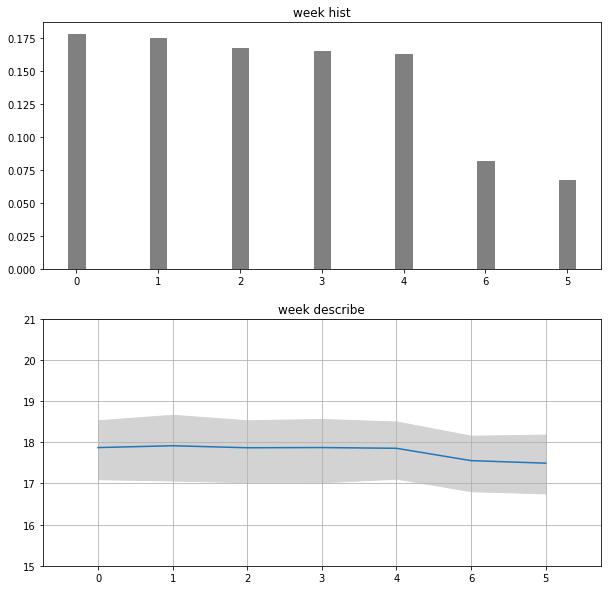

In [14]:
plotclass('week')

我们创建一个新的特征 holiday，可以标记处是否处于感恩节以及圣诞节假期

In [15]:
pd.Timestamp('2016-12-25')-pd.Timestamp('2016-8-1')

Timedelta('146 days 00:00:00')

## 5. socialEngagementType

In [16]:
idx = (train.socialEngagementType != 'Not Socially Engaged')
sum(idx)

0

In [17]:
train.drop(['socialEngagementType'], axis=1, inplace=True)

## 6. visitNumber

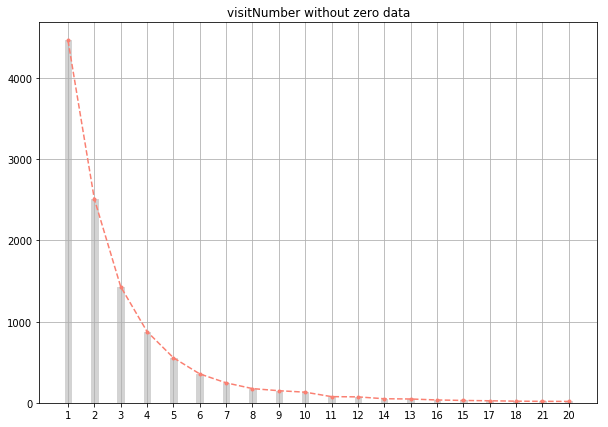

In [18]:
def plotvisitnumber():
    vn1 = train.visitNumber.value_counts(dropna=False)[0:20]
    plt.figure(figsize=[10,7])
    plt.bar(np.arange(vn1.shape[0])+1,
            vn1.values,
            facecolor='lightgray',
            width=np.ones(20)*0.25,
            edgecolor='lightgray',
            tick_label=vn1.index.values)
    plt.plot(np.arange(vn1.shape[0])+1,
             vn1.values,'.--', 
             c='salmon')
    plt.title('visitNumber without zero data')
    plt.grid()
    plt.show()
    return None


plotvisitnumber()

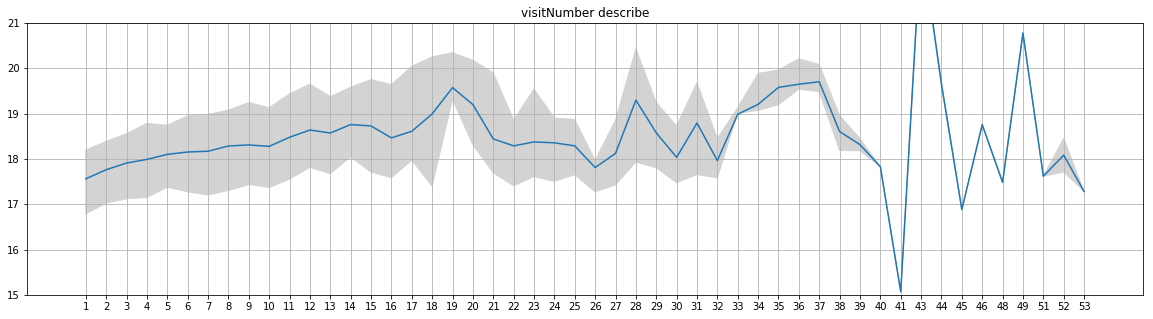

In [19]:
def plotvisit(features,df=train,top=False,size=[10,5],score='target'):
    feature = []
    featurelist = ['count','mean','std','min','25%','50%','75%','max']
    for i in featurelist:
        feature.append(df.groupby(features).describe()[score][0:top][i]) 
    shape = feature[0].shape[0]
    plt.figure(figsize=size)
    plt.bar(np.arange(shape),
                np.zeros(shape),
                tick_label=feature[0].index.values)
    plt.plot(np.arange(shape),
             feature[1].values)
    plt.fill_between(np.arange(shape),
                     feature[4].values,
                     feature[6].values,
                     color='lightgray')
    plt.grid()
    plt.title(f'{features} describe')
    plt.ylim([15,21])
    plt.show()
    return None

plotvisit('visitNumber', top=50, size=[20,5])

##### 结论：保留visitNumber

## 7. visitStartTime
The timestamp (expressed as POSIX time)， so we convert it to a pd.datatime

In [20]:
def totime(t):
    year = time.localtime(t)[0]
    month = time.localtime(t)[1]
    day = time.localtime(t)[2]
    hour = time.localtime(t)[3]
    minute = time.localtime(t)[4]
    second = time.localtime(t)[5]
    return pd.Timestamp(year,month,day,hour,minute,second)


train['visitStartTime'] = train.visitStartTime.map(totime)

In [94]:
train['hour'] = train.visitStartTime.apply(lambda x: x.hour)

In [101]:
train['day'] = train.date.apply(lambda t: t.dayofyear)

这个features, 因为使用的是UTC，所以在时间上面有一定偏移，在之后的工作中，如果我们能否通过所在地区找到其时区，便能探索具体时间对于结果的影响。

## 8. 去掉重复features

In [21]:
for i in train.columns:
    if sum(train[i] == train[i][0]) == train.shape[0]:
        train.drop([i], axis=1, inplace=True)
print(f'After drop feature Number is: {train.shape[1]}')

After drop feature Number is: 38


## 9. device

In [22]:
train.iloc[:,6:10].head()

,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem
0,Chrome,desktop,False,Linux
1,Chrome,desktop,False,Macintosh
2,Chrome,desktop,False,Linux
3,Chrome,desktop,False,Windows
4,Chrome,desktop,False,Macintosh


In [23]:
# 我们去掉device_isMobile
train.drop(['device_isMobile'], axis=1, inplace=True)

我们可以看到device_operatingSystem 有较多(not set)项目 

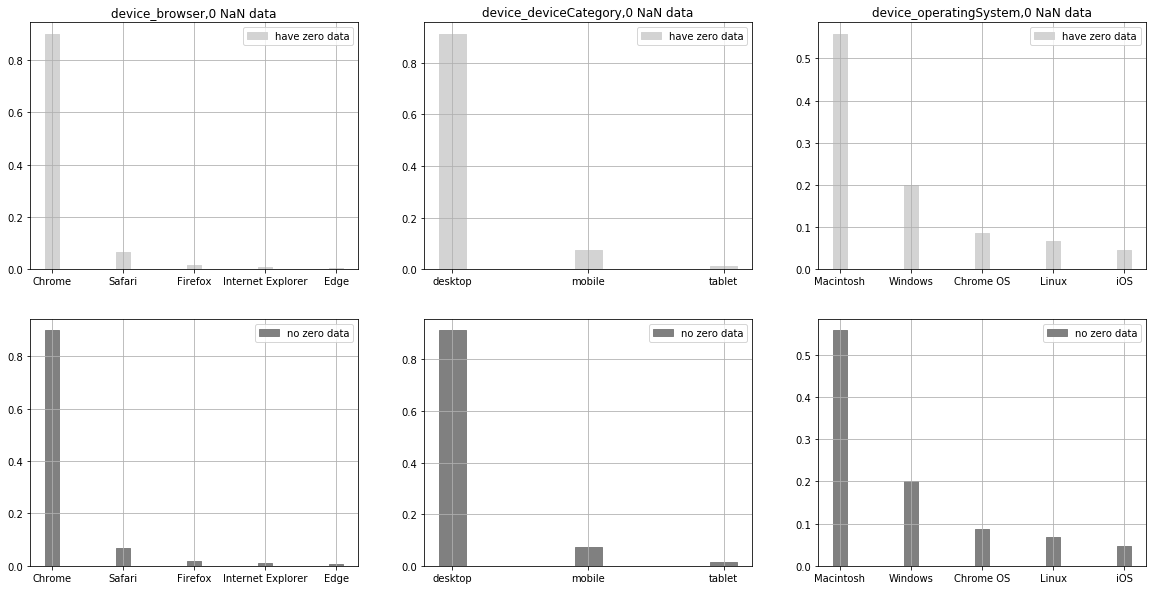

In [24]:
def plotdevice(df,top=10):
    n = 1
    plt.figure(figsize=[20,10])
    for i in df.columns[6:9]:
        idx = train.totals_transactionRevenue.notnull()
        value_count1 = train[i].value_counts(dropna=True,normalize=True)[0:top]
        value_count2 = train[idx][i].value_counts(dropna=True,normalize=True)[0:top]
        plt.subplot(2,3,n)
        plt.bar(np.arange(value_count1.shape[0])+1,
                value_count1.values,           
                width=np.ones(value_count1.shape[0])*0.2,
                facecolor='lightgray',
                edgecolor='lightgray',
                tick_label=value_count1.index.values,
                label='have zero data')
        plt.legend()
        plt.title(f'{i},{sum(train[i].isnull())} NaN data')
        plt.grid()
        plt.subplot(2,3,n+3)
        plt.grid()
        plt.bar(np.arange(value_count2.shape[0])+1.2,
                value_count2.values,           
                width=np.ones(value_count2.shape[0])*0.2,
                facecolor='gray',
                edgecolor='gray',
                tick_label=value_count2.index.values,
                label='no zero data')
        plt.legend()
        n = n+1
    plt.show()
    return None


plotdevice(train,top=5)

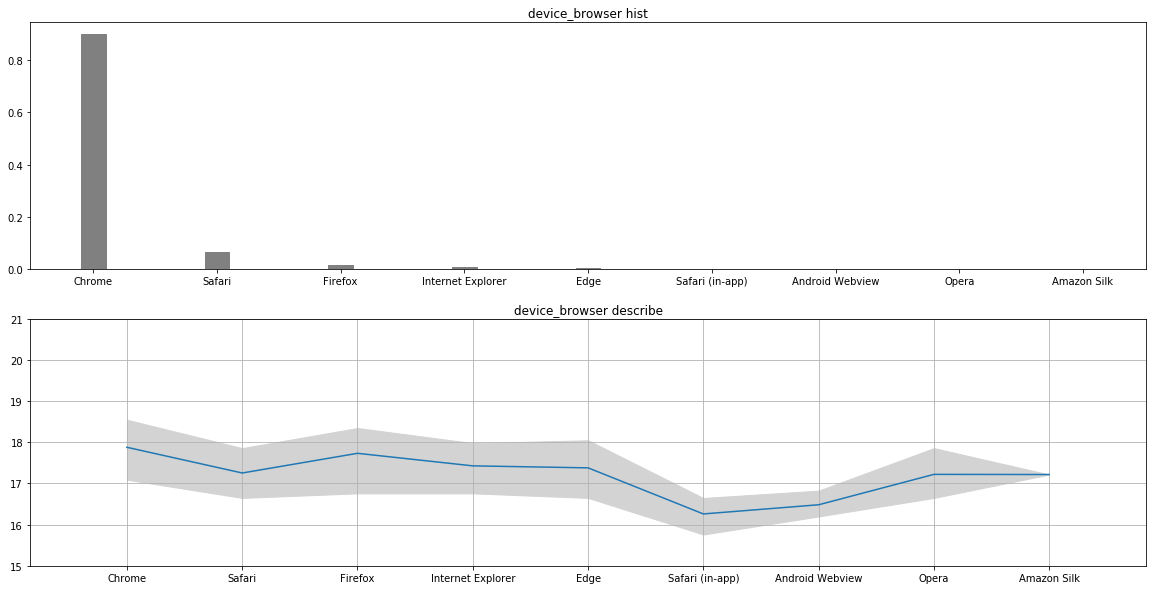

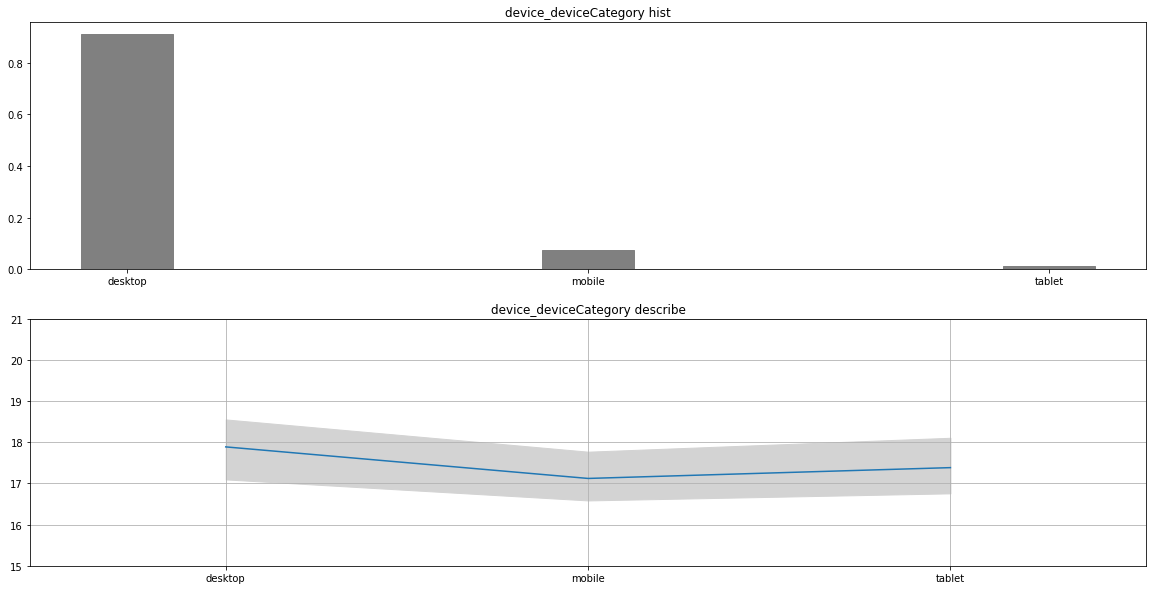

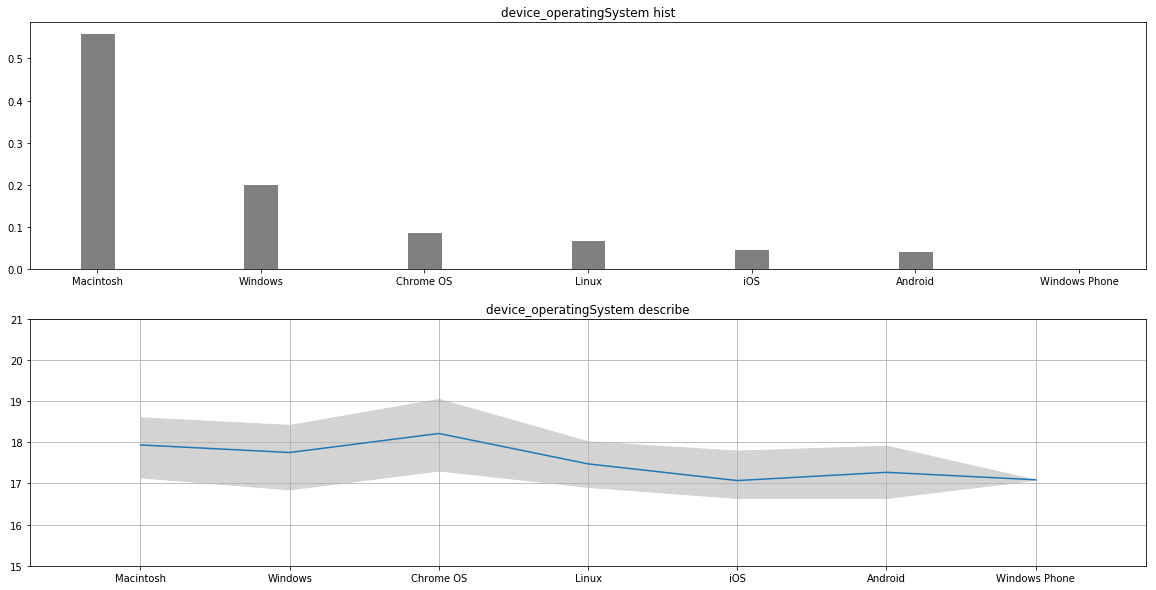

In [25]:
for col in train.columns[6:9]:
    plotclass(col,top=10,size=[20,10])

##### 结论：取前10， all onehot


## 10. geoNetwork

In [26]:
train.iloc[:,9:16].head()

,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent
0,Ann Arbor,Americas,United States,Detroit MI,(not set),Michigan,Northern America
1,New York,Americas,United States,New York NY,(not set),New York,Northern America
2,New York,Americas,United States,New York NY,(not set),New York,Northern America
3,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America
4,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America


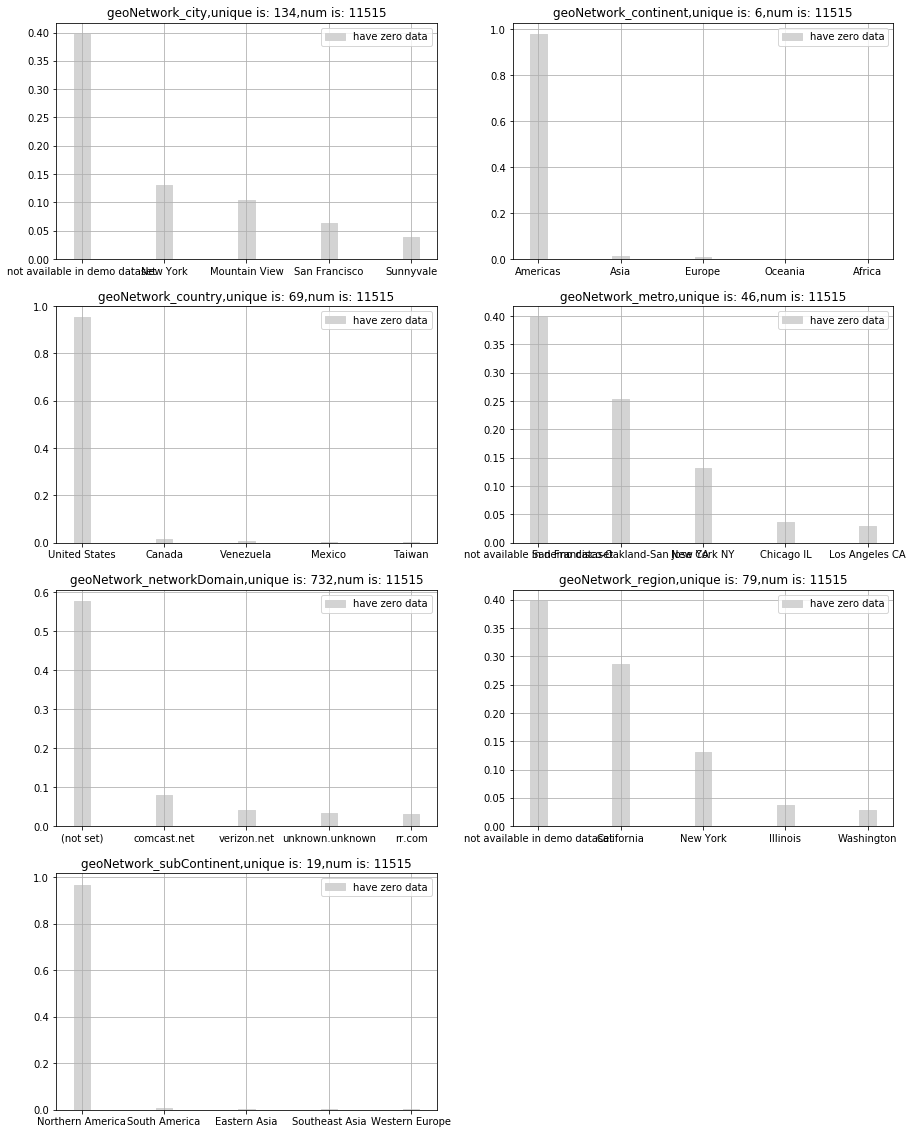

In [27]:
def plotgeonetwork(df,top=10):
    n = 1
    plt.figure(figsize=[15,20])
    for i in df.columns[9:16]:
        value_count1 = df[i].value_counts(dropna=True,normalize=True)[0:top]
        plt.subplot(4,2,n)
        plt.bar(np.arange(value_count1.shape[0])+1,
                value_count1.values,           
                width=np.ones(value_count1.shape[0])*0.2,
                facecolor='lightgray',
                edgecolor='lightgray',
                tick_label=value_count1.index.values,
                label='have zero data')
        plt.legend()
        plt.title(f'{i},unique is: {df[i].nunique()},num is: {sum(df[i].notnull())}')
        plt.grid()
        n = n+1
    plt.show()
    return None


plotgeonetwork(train,top=5)

In [28]:
sum(train.geoNetwork_city.value_counts()[0:20]/train.shape[0])

0.9377333912288316

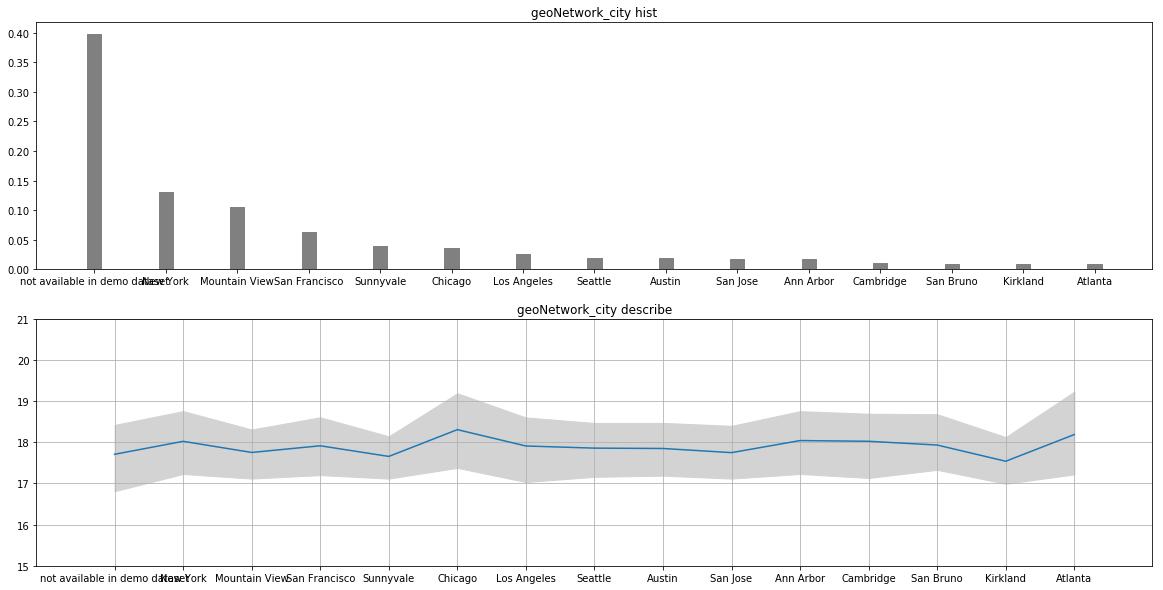

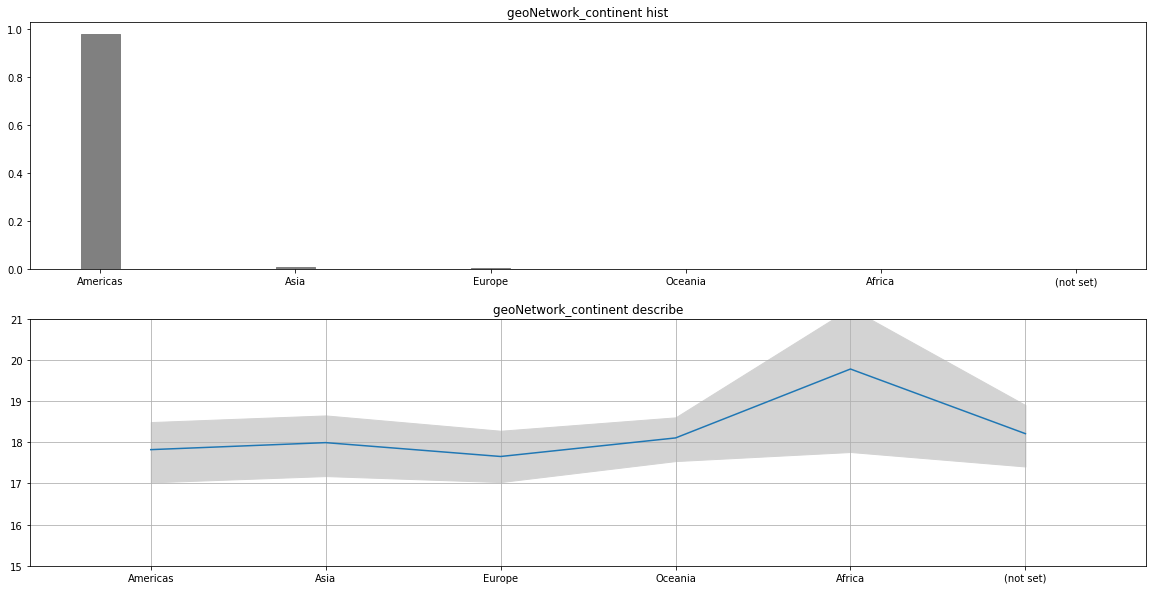

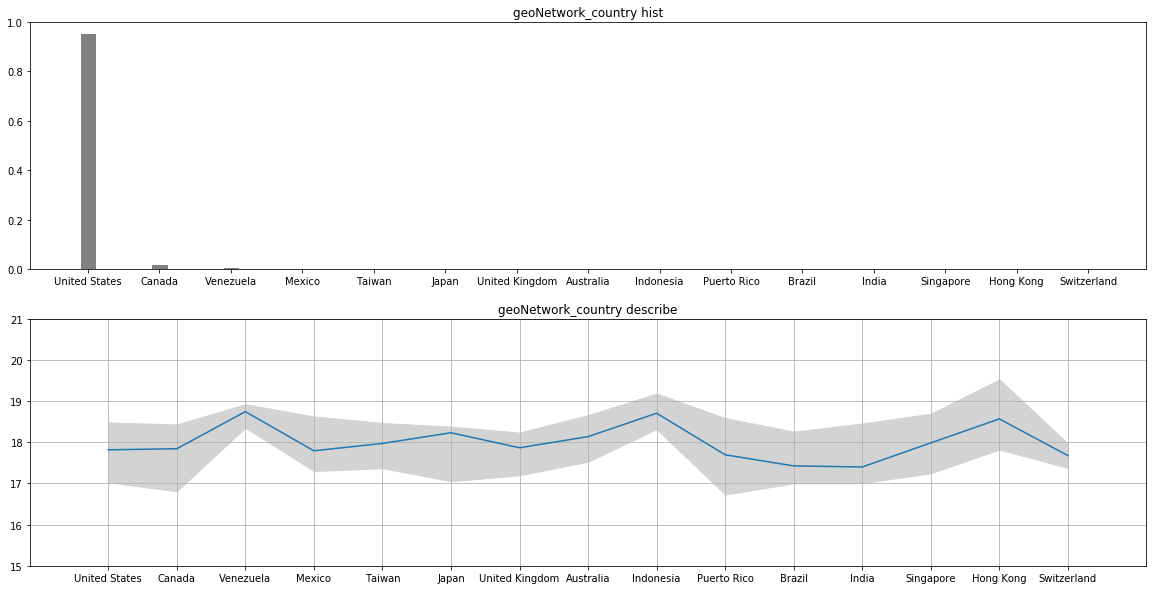

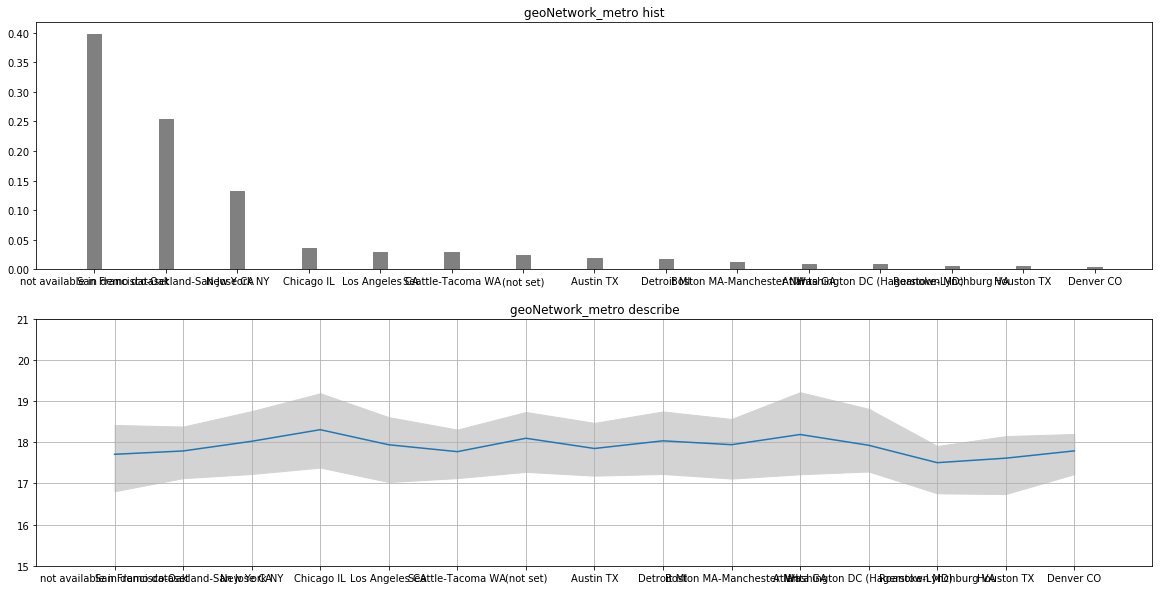

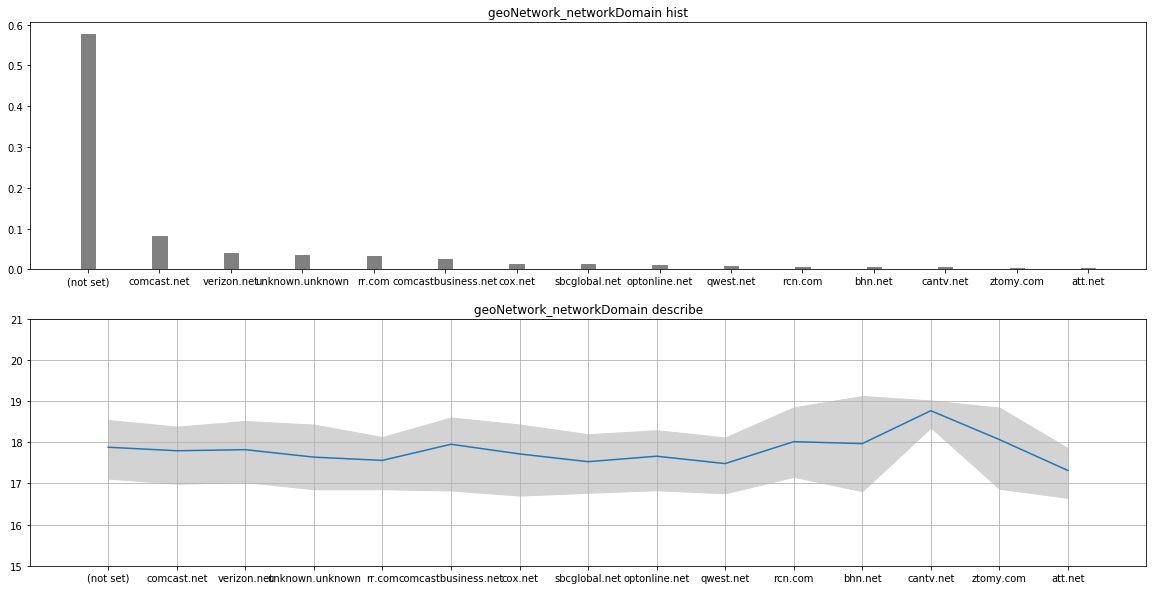

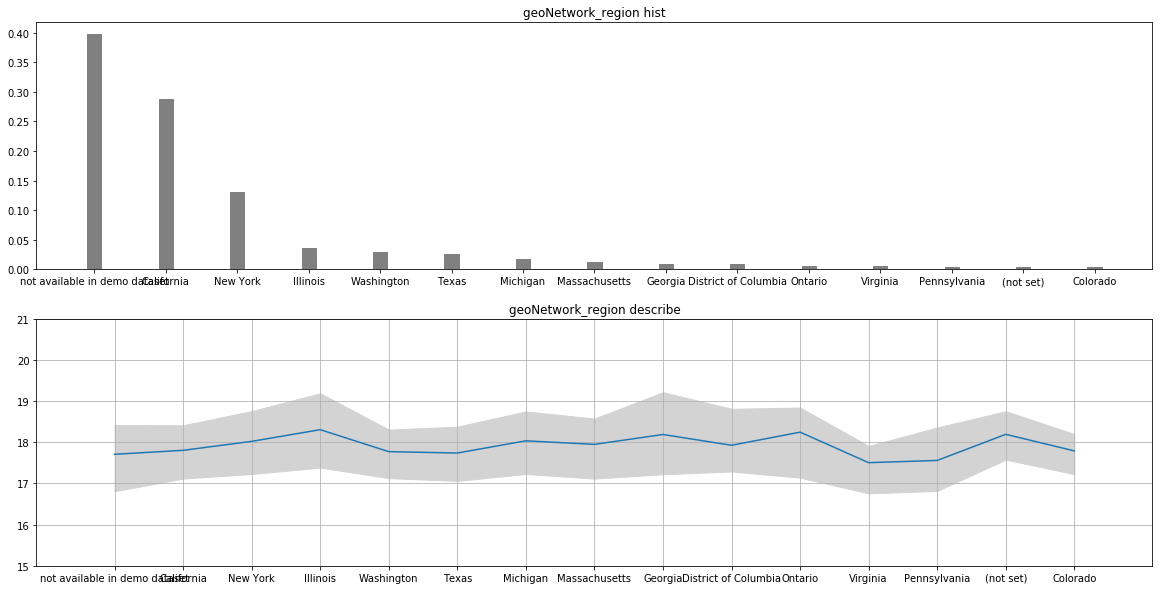

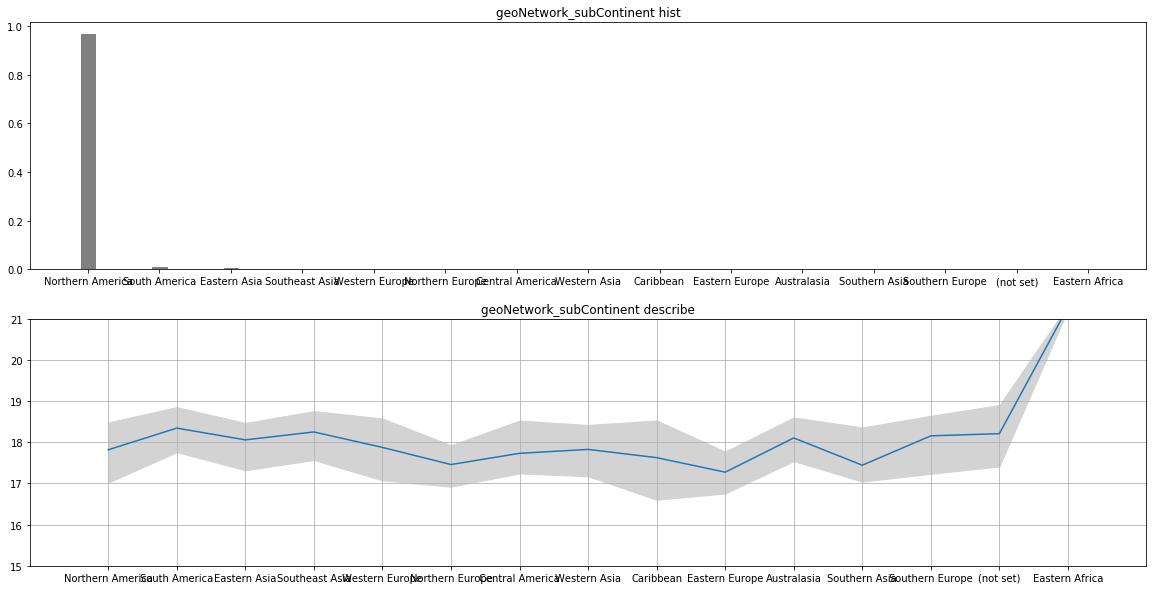

In [29]:
for i in train.columns[9:16]:
    plotclass(i,top=15,size=[20,10])

啊哈，一个有趣的发现，那就是city中的的not available in demo dataset其实是在city，metro,region都是not available in demo dataset的。而在其他几项中并没有明显不同

###### 建议：去掉geoNetwork_continent，geoNetwork_country，geoNetwork_subContinent，geoNetwork_metro，geoNetwork_region ,剩下的保留20个然后onehot

## 11. totals

In [30]:
train.iloc[:,16:20].head()

,totals_bounces,totals_hits,totals_newVisits,totals_pageviews
0,None,11,1,11
1,None,11,None,10
2,None,13,None,11
3,None,13,None,12
4,None,17,None,14


In [31]:
train['totals_bounces'] = train.totals_bounces.fillna(0)
train['totals_newVisits'] = train.totals_newVisits.fillna(0)


In [32]:
train.iloc[:,16:20].head()

,totals_bounces,totals_hits,totals_newVisits,totals_pageviews
0,0,11,1,11
1,0,11,0,10
2,0,13,0,11
3,0,13,0,12
4,0,17,0,14


In [33]:
train['totals_bounces'] = train.totals_bounces.astype('float')
train['totals_hits'] = train.totals_hits.astype('float')
train['totals_newVisits'] = train.totals_newVisits.astype('float')
train['totals_pageviews'] = train.totals_pageviews.astype('float')

In [34]:
def plottotals(df,top=5):
    n = 1
    plt.figure(figsize=[10,10])
    for i in df.columns[17:20]:
        idx = df.totals_transactionRevenue.notnull()
        value_count1 = df[i].value_counts(dropna=True,normalize=True)[0:top]
        value_count2 = df[idx][i].value_counts(dropna=True,normalize=True)[0:top]
        plt.subplot(2,2,n)
        plt.bar(np.arange(value_count1.shape[0])+1,
                value_count1.values,           
                width=np.ones(value_count1.shape[0])*0.2,
                facecolor='lightgray',
                edgecolor='lightgray',
                tick_label=value_count1.index.values,
                label='have zero data')
        plt.legend()
        plt.title(f'{i},unique is: {df[i].nunique()}')
        plt.grid()
        n = n+1
    plt.show()
    return None


plottotals(train,top=20)

KeyError: 0.0

<Figure size 720x720 with 0 Axes>

In [ ]:
for i in train.columns[17:20]:
    plotvisit(i,top=20,size=[10,5])

In [35]:
train['cut'] = train.totals_hits.astype('float') - train.totals_pageviews.astype('float')

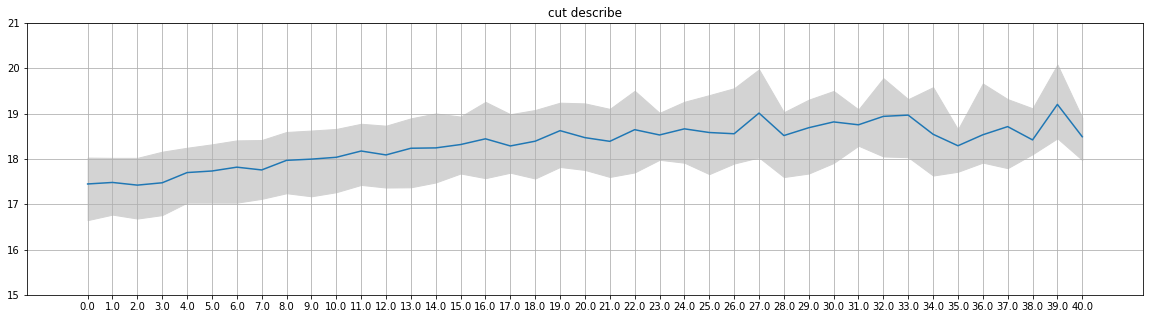

In [36]:
plotvisit('cut',top=40,size=[20,5])

##### 结论：新特征cut，删除totals_bounces，totals_hits，totals_pageviews

### trafficSource

In [37]:
train.iloc[:,21:34].head()

,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,None,None,None,None,None,None,(not set),None,True,None,(none),None,(direct)
1,None,None,None,None,None,None,(not set),None,True,(not provided),organic,None,google
2,None,None,None,None,None,None,(not set),None,True,None,referral,/,mall.googleplex.com
3,None,None,None,None,None,None,(not set),None,True,None,referral,/,mall.googleplex.com
4,None,None,None,None,None,None,(not set),None,True,None,referral,/,mall.googleplex.com


In [ ]:
droplist = [
    'trafficSource_adwordsClickInfo.adNetworkType',
    'trafficSource_adwordsClickInfo.gclId',
    'trafficSource_campaignCode',
    'trafficSource_adwordsClickInfo.isVideoAd',
    'rafficSource_adwordsClickInfo.page',
    'trafficSource_adwordsClickInfo.slot',
    'trafficSource_campaign',
    'trafficSource_keyword',
    'trafficSource_medium']
train.drop(droplist,axis=1,inplace=True)

In [ ]:
train.iloc[:,21:26].head()

In [38]:
train['haveid'] = train['trafficSource_adwordsClickInfo.page'].notnull().astype('float')

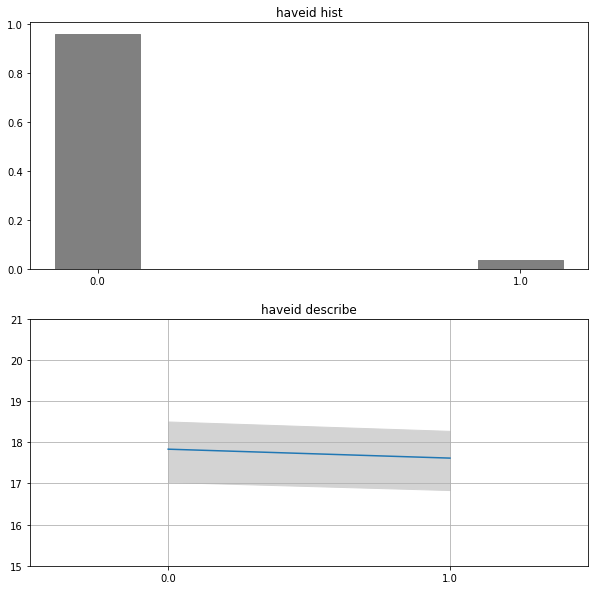

In [39]:
plotclass('haveid')

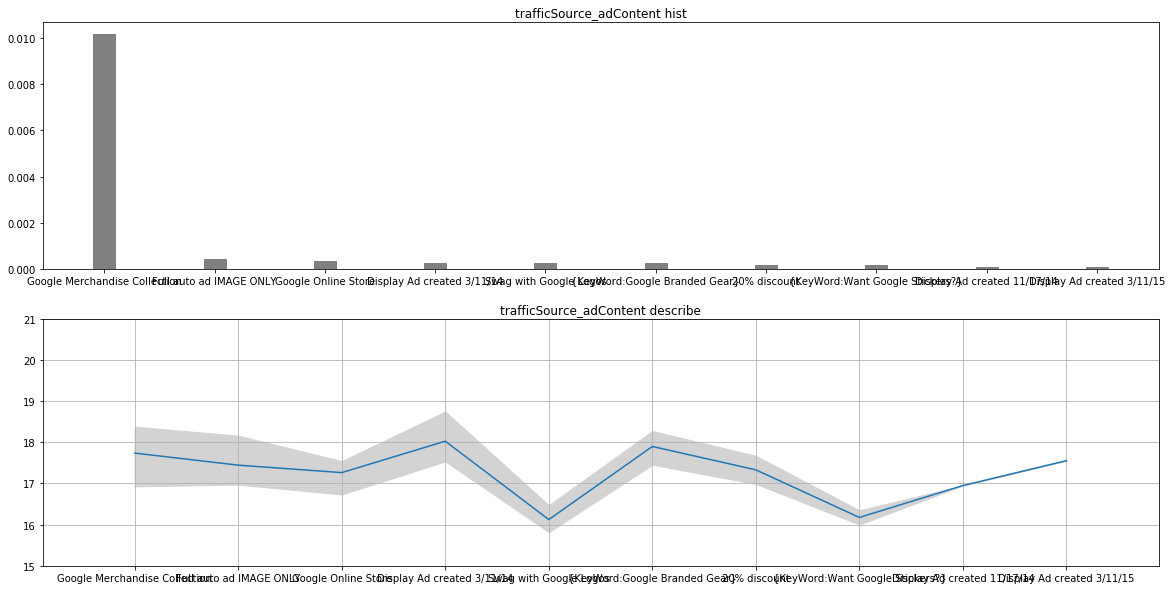

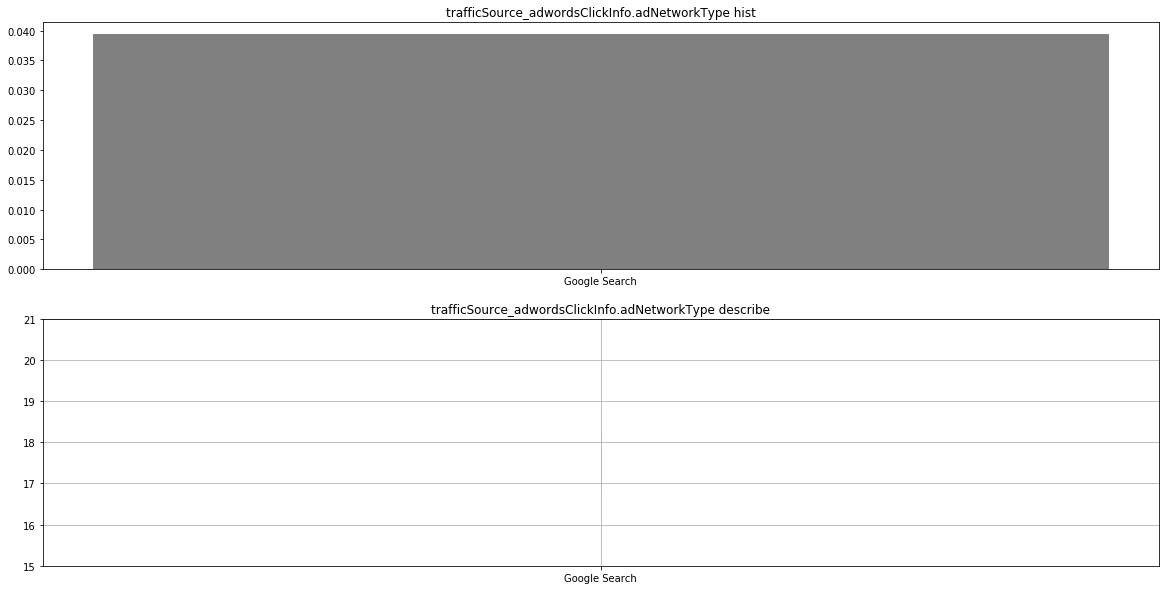

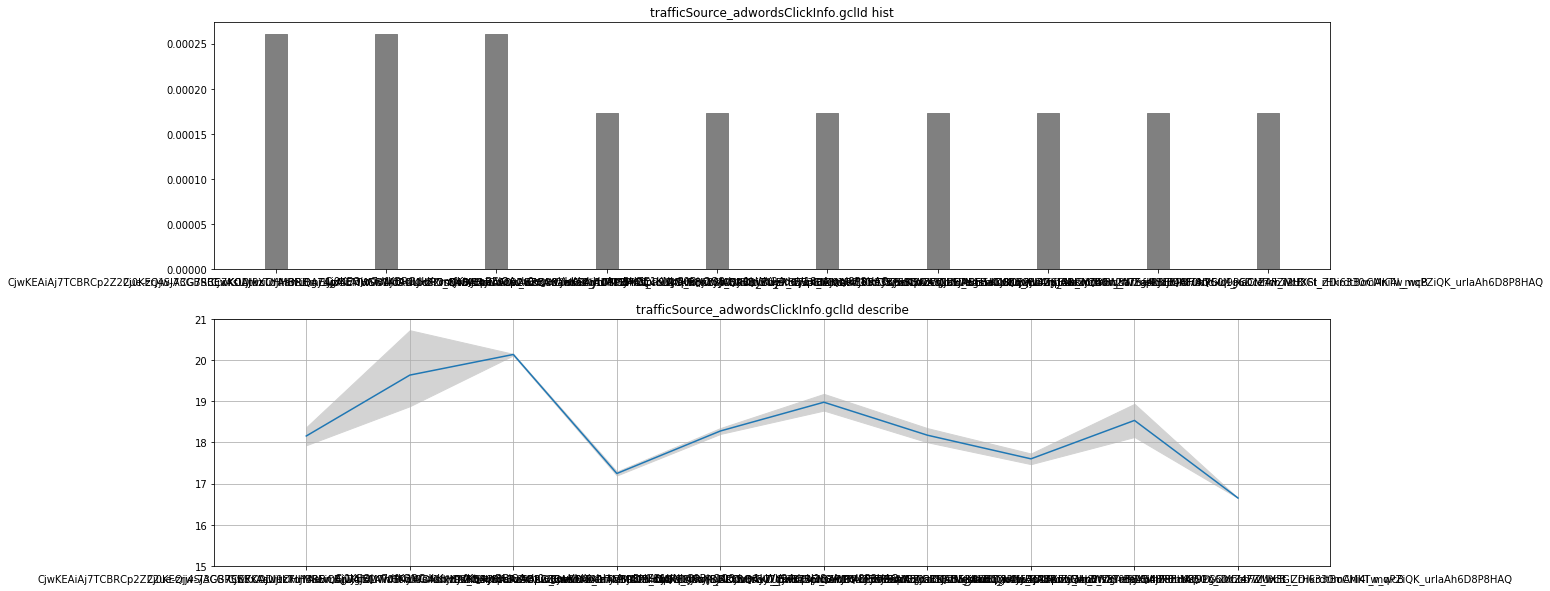

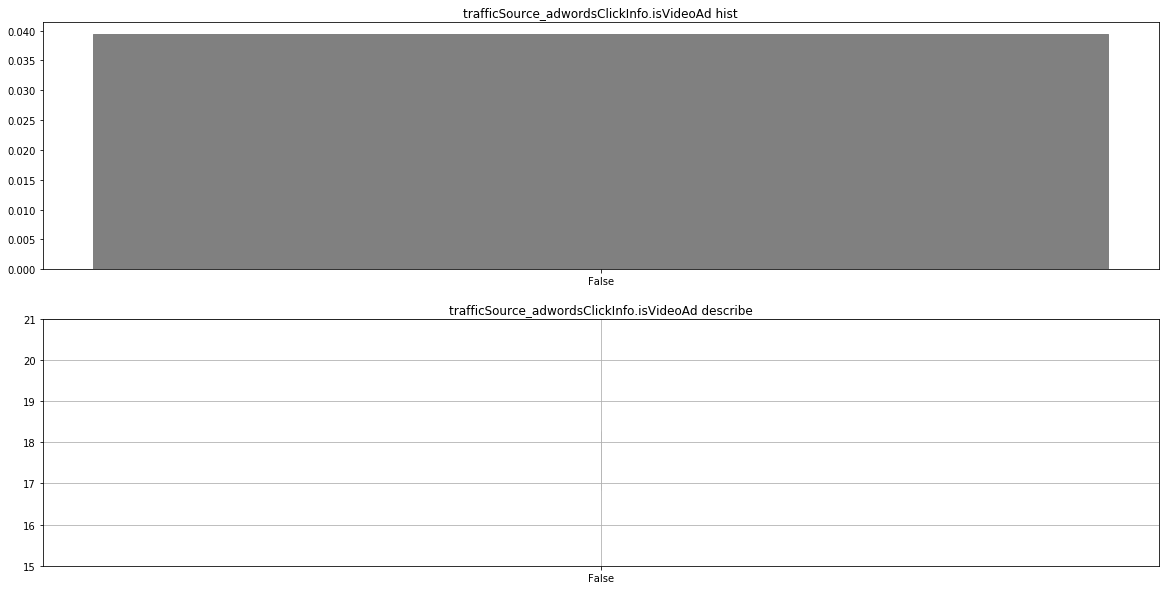

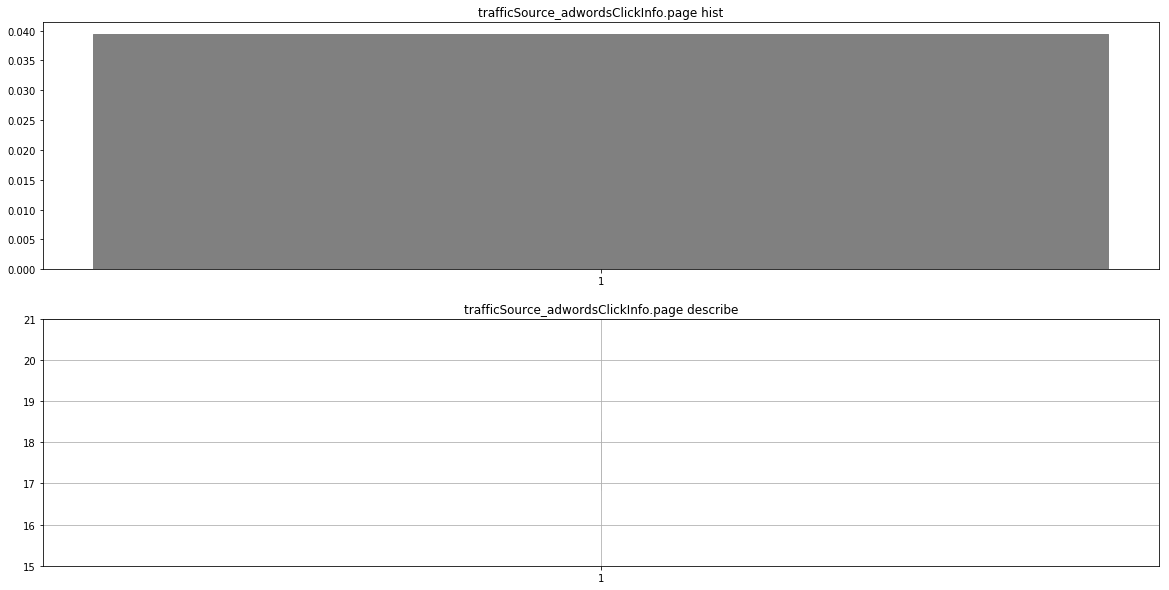

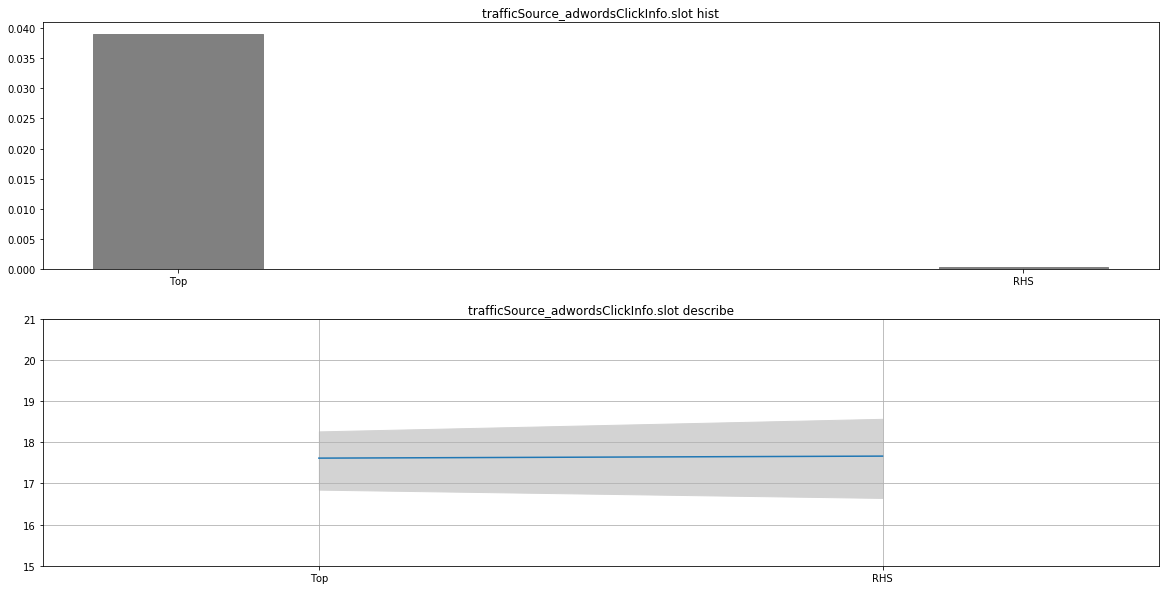

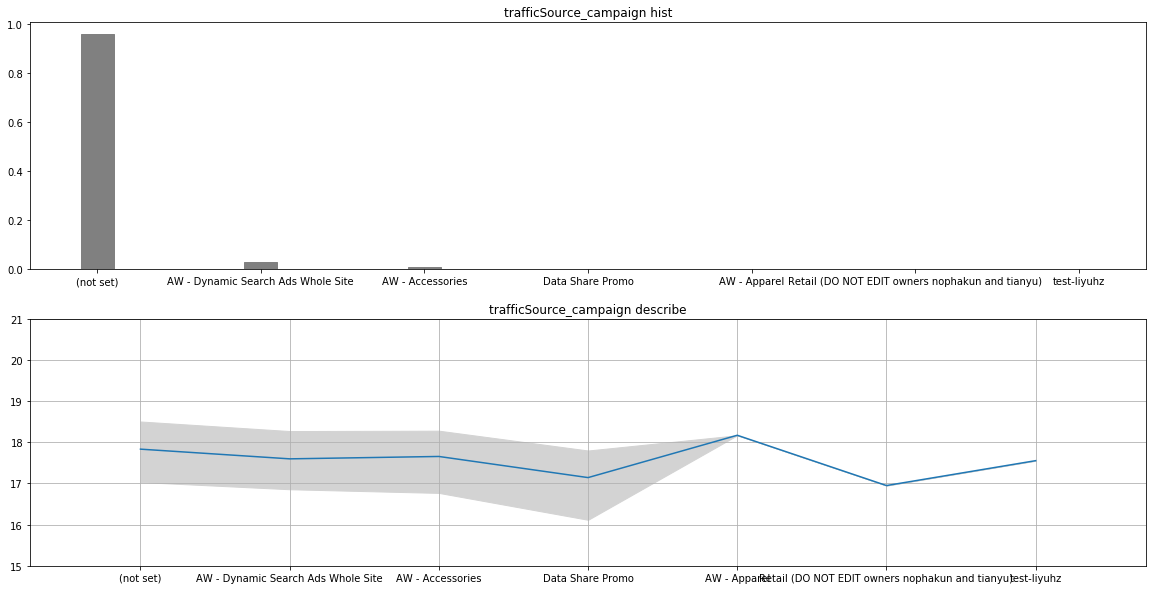

KeyError: 'target'

In [46]:
for i in train.columns[21:34]:
    plotclass(i,top=10,size=[20,10])

## 探索Nan的分布

### 结论：我对上述几项进行了两两对比，并且与channelgroup等项进行了对比，发现：      
1. referralPath项，只有当medium为referral时，才有值      
2. campaignCode：11251kjhkvahf    
3. adContent项是google广告中出现的词，将近一半与ClickInfo类，campaign，gclId有交集，但是是哪一半？啊，我们找到了一些，如果广告词中出现了'google'那么这两项的值就是共同存在的      
4. Clickinfo 类与campaign，gclId的值域基本重合，并且每一个都有关键词   
5. gclId项是google 点击 ID.   
6. 如果您服务器上的网址重写引擎更改了自动标记 gclid 值的大小写，如将 gclid=TeSter 改写为全部小写的 gclid=tester，则 Google Analytics（分析）会无法确定哪次 Google Ads 点击与哪个会话相关。如果存在任何 gclid 参数，那么系统会将数据来源识别为 source=google 和 medium=cpc，但所有其他特定于点击的数据（例如广告系列、广告组、关键字等）将在 Google Analytics（分析）报告中显示为 (not set)。   
7. gclid 与 channelGroup 中的Paid Search 高度重合，所有data如果存在gclid 那么必然来源于 付费搜索，这也就解释了为什么referralPath不与其他项相交，因为referralPath 必然来源于 referral和social。

## 探索train.trafficSource值之间的关系

In [ ]:
train.columns[21:33]

In [ ]:
idx1 = train.channelGrouping != 'Direct'
idx2 =  train.trafficSource_isTrueDirect.notnull()
idx = idx1 & idx2
print(sum(idx),sum(idx1),sum(idx2),sum(train.channelGrouping=='Referral'))
print(train.channelGrouping.value_counts())
print(train.trafficSource_medium.value_counts())

In [ ]:
idx = train.trafficSource_isTrueDirect.notnull()
train[idx].channelGrouping.value_counts()

### 结论：
1. medium项与channelgroup高度重合，只是medium中的referral在Organic Search中被拆分成了Social与Direct，所以建议删除trafficSource_medium
2. 可以删除trafficSource_adwordsClickInfo.isVideoAd，因为没有意义
3. 可以删除trafficSource_adwordsClickInfo.adNetworkType，没啥意义
4. 可以删除trafficSource_adwordsClickInfo.page 和 trafficSource_adwordsClickInfo.slot ，也没啥意义
5. 建议删除trafficSource_keyword，trafficSource_campaign，还是没啥意义

### 所以我们剩下什么了？
1. 'trafficSource_adContent'：只有cahnnelgrouping 为Paid Search时才有值，并且出项google时便会拥有一个gclid   
2. 'trafficSource_adwordsClickInfo.gclId'：我还没想出怎么去利用这一串乱码，并且只有cahnnelgrouping 为Paid Search时才有值，并且一个fullVisitorId只对应一个gclid,其实吧，可以吧是否存在gclid作为一个feature，然后把这个删掉。。。
#### important! 
3. 'trafficSource_isTrueDirect'：如果会话的来源是“Direct”（表示用户在浏览器中输入了您网站网址的名称或是通过书签访问了您的网站），则为 True；如果 2 个连续但不同的会话具有完全相同的广告系列详细信息，则此字段也为 true。否则为 NULL。所以，我们可以把这两种情况区分开。
4. 'trafficSource_referralPath' ：如果 trafficSource.medium 为“referral”，则此值为引荐来源网址的路径。（引荐来源网址的主机名包含在 trafficSource.source 中。）只有cahnnelgrouping 为 referral 和 Social 的这一项才有值，我们似乎可以从这里也找到一些出国别之类或者习惯之类的信息。  
5. 'trafficSource_source'：流量来源。可以是搜索引擎的名称、引荐来源网址的主机名或 utm_source 网址参数的一个值。

In [ ]:
idx = (train.trafficSource_isTrueDirect.notnull()) & (train.channelGrouping != 'Direct') 
idx2 = train.totals_transactionRevenue.notnull()
print(train[idx].channelGrouping.value_counts())
print(sum(idx),sum(idx & idx2))

### 新的特征：
我们现在可以创建一个新的特征，当istrueDirect不为空，channelgrouping不为direct，totoals_bounces为0，创建新特征 isTrueDirect ，这个特征貌似有非常好的效果。
并且，我们可以把trafficSource_source 和 trafficSource_referralPath 拼接起来。组成一个新的特征 path。

In [40]:
train['direct'] = (train.channelGrouping!='direct') & (train.trafficSource_isTrueDirect.notnull())

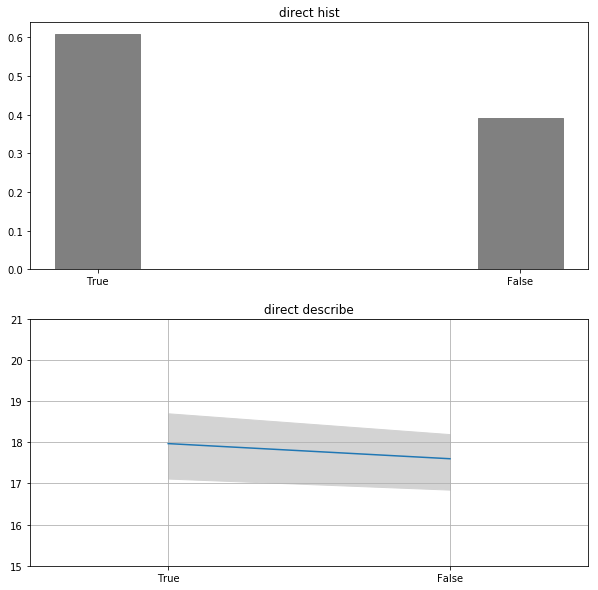

In [41]:
plotclass('direct')

In [42]:
train['path'] = train.trafficSource_source +  train.trafficSource_referralPath.fillna('') 

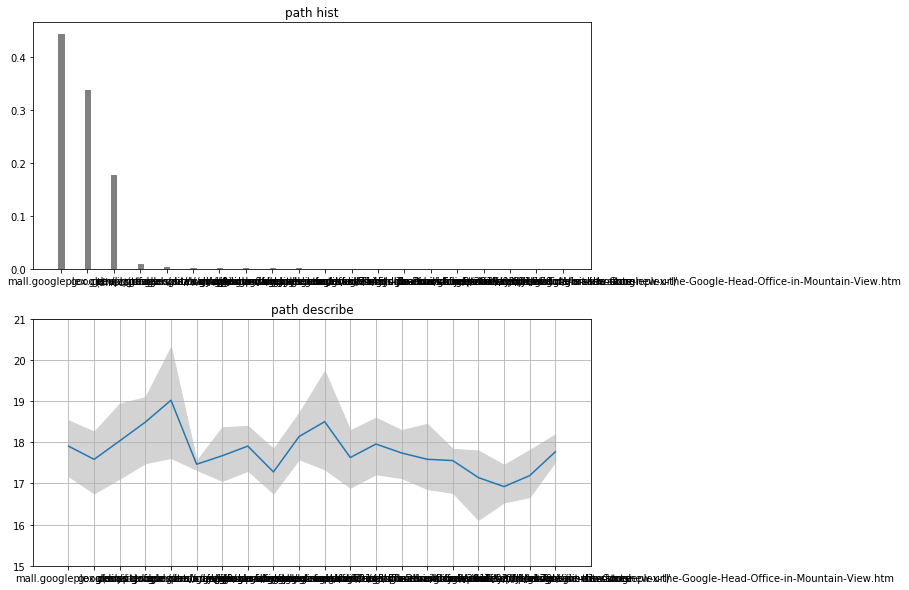

In [43]:
plotclass('path',top=20)

In [ ]:
idx = train.totals_transactionRevenue.notnull()

for i in train.columns[21:33]:
    print('\n',
          train[i].value_counts(),
          '\n',
          'len is: ', train[i].value_counts().shape[0],
          'Num is: ',sum(train[i].notnull()),
          'Nan is: ',sum(train[i].isnull()),
          '\n',
          '-'*80,
          '\n',
          train[idx][i].value_counts(),      
          '\n',
          'len is: ',train[idx][i].value_counts().shape[0],
          'Num is: ',sum(train[idx][i].notnull()),
          'Nan is: ',sum(train[idx][i].isnull()),
          '\n',
          '*'*80)

In [ ]:
print(
    train.path.value_counts()[0:10],
    'Num is: ',sum(train[i].notnull()),
    '\n','*'*40,'\n')

### 建议：
去掉 trafficSource_source 和 trafficSource_referralPath 